![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Joe |
<b>Student-nr</b>: KD6-3.7 |
<b>Date</b>: July 1, 2049
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are:
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication.
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes.

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties.

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [ ]:
import numpy as np
import cv2
from pathlib import Path
import random
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
# Setting seeds for Python, NumPy, and TensorFlow
random.seed(42)
np.random.seed(42)
# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when needed throughout this notebook,
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module.
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

* [The CALTECH Faces dataset](https://data.caltech.edu/records/6rjah-hdv18) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data.

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn.


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm
* target: N-dimensional vector of labels

In [ ]:
# size of each face after preprocessing
face_size=(47, 47)

In [ ]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    return gray, imagePath.parent.name

# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully
# Please note that 5 images were removed from the original set, because
# they wouldn't match the corresponding individual.
print(len(data['images']))
assert len(data['images']) == len(data['target']) == 445

445


### 2. Inspect some images

In [ ]:
'''fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),
                 axes_pad=0.1,
                 )
for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)'''

"fig = plt.figure(figsize=(20, 20))\ngrid = ImageGrid(fig, 111,\n                 nrows_ncols=(5, 21),\n                 axes_pad=0.1,\n                 )\nfor ax, im in zip(grid, data['images']):\n    # Iterating over the grid returns the Axes.\n    ax.imshow(im, cmap = 'gray')\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)"

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes.

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1).

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [ ]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [ ]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder
import pickle

try:
    with open('faces.pkl', 'rb') as f:
        faces = pickle.load(f)
except:
    feat_data, images, labels = [], [], []


    for img, label in zip(data['images'], data['target']):
        faces = faceCascade.detectMultiScale(
            img,
            scaleFactor = 1.2,
            minNeighbors = 9,
            minSize = (30, 30),
            flags = cv2.CASCADE_SCALE_IMAGE
        )

        # iterate faces found in image
        for (x, y, w, h) in faces:
            new_img = img.copy()

            # extract ROI
            raw_face = new_img[y:y+h, x:x+w]

            # resize the face to the preferred size
            face = cv2.resize(raw_face, face_size)
            face_flatten = face.flatten()

            images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

    # encode classes as integer value
    label_encoder = LabelEncoder()
    targets = label_encoder.fit_transform(labels)

    faces = Bunch(data       = np.array(feat_data),
                  images     = np.array(images),
                  labels     = np.array(labels),
                  target     = np.array(targets))
    with open('faces.pkl', 'wb') as f:
        pickle.dump(faces, f)

In [ ]:
faces.target[10]

20

### 2. Print statistics of data

In [ ]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

In [ ]:
'''fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)'''

"fig = plt.figure(figsize=(10, 10))\ngrid = ImageGrid(fig, 111,\n                 nrows_ncols=(10, 10),\n                 axes_pad=0.1,\n                 )\n\nfor ax, im in zip(grid, faces['images']):\n    # Iterating over the grid returns the Axes.\n    ax.imshow(np.mean(im, -1), cmap = 'gray')\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)"

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping.

In [ ]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True,
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion?

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition.

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [ ]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca

    dist_metric = euclidean

### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda

    dist_metric = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [ ]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])

    dist_metric = chisquare

# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms.
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics.

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification.
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations.
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br>

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function.
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large.







There is a very elegant Python implementation available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface.

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough.

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [ ]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese
import tensorflow
tensorflow.random.set_seed(42)

#some older versions may need this
# import tensorflow as tf
# tf.enable_eager_execution()


encoder, model = siamese.create_siamese_model(imshape, num_components)
model.summary()

Model: "model_191"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_250 (InputLayer)      [(None, 47, 47, 1)]          0         []                            
                                                                                                  
 input_251 (InputLayer)      [(None, 47, 47, 1)]          0         []                            
                                                                                                  
 sequential_165 (Sequential  (None, 35)                   299107    ['input_250[0][0]',           
 )                                                                   'input_251[0][0]']           
                                                                                                  
 lambda_100 (Lambda)         (None, 1)                    0         ['sequential_165[0][0]

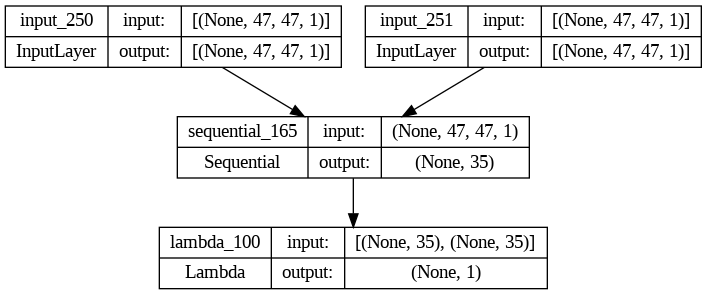

In [ ]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [ ]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import os  # Import os module for file checking
import tensorflow
tensorflow.random.set_seed(42)

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    print(x_train.shape)
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model_checkpoint = ModelCheckpoint('best_siamese.h5',
                                       monitor='val_loss',
                                       mode='min',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False)

    # Check if the weights file exists
    if os.path.exists('best_siamese.h5'):
        # Load the weights if the file exists
        model.load_weights('best_siamese.h5')
        print("Weights loaded from 'best_siamese.h5'")
    else:
        # Train the model if the weights file doesn't exist
        model.fit([x_train[:, 0], x_train[:, 1]], y_train,
                  validation_split=0.2,
                  batch_size=32, verbose=2, epochs=epochs,
                  callbacks=[model_checkpoint])

    # Evaluate the model on the test set
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean


(1500, 2, 47, 47, 1)
Weights loaded from 'best_siamese.h5'
16/16 [==============================] - 1s 32ms/step
Accuracy on the test set: 0.99


## IV. Mandatory tasks

<b>The student should do all of the tasks indicated in this section</b>.
 All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


## 1. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used.

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting


On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score.

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [ ]:
# Calculate pairwise distance based on the given function
def calc_pairwise(embeddings, dist):
  pairwise = np.zeros((len(faces["images"]), len(faces["images"])))
  for i in range(len(embeddings)):
      for j in range(len(embeddings)):
          pairwise[i,j] = dist(embeddings[i], embeddings[j])
  return pairwise

# CHI squared from above
def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

In [ ]:
# Compute a PCA (eigenfaces) on the face dataset
try:
    pairwise_pca = np.load("pairwise_pca.npy")
except:
    # Get components
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    # Initialize PCA as above
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    # Transform data
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    dist_metric = euclidean
    # Calc distance
    pairwise_pca = calc_pairwise(embedded_pca, dist_metric)
    np.save("pairwise_pca.npy", pairwise_pca)

num_components 35


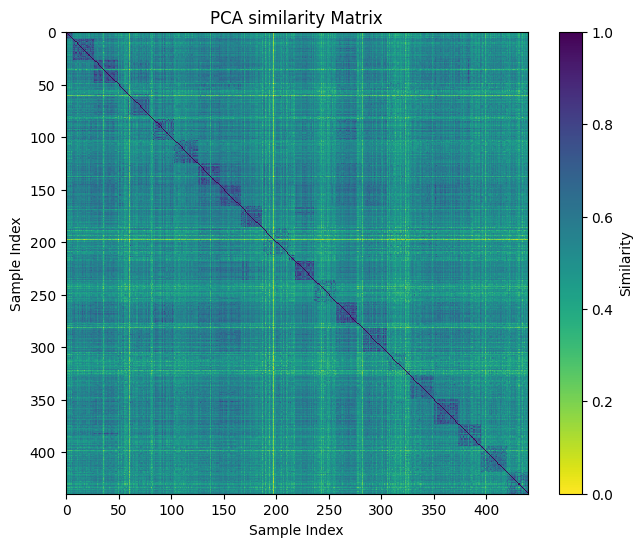

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow((np.max(pairwise_pca)-pairwise_pca)/np.max(pairwise_pca), cmap='viridis_r', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('PCA similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

In [ ]:
try:
    pairwise_lda = np.load("pairwise_lda.npy")
except:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    dist_metric = euclidean
    pairwise_lda = calc_pairwise(embedded_lda, dist_metric)
    np.save("pairwise_lda.npy", pairwise_lda)

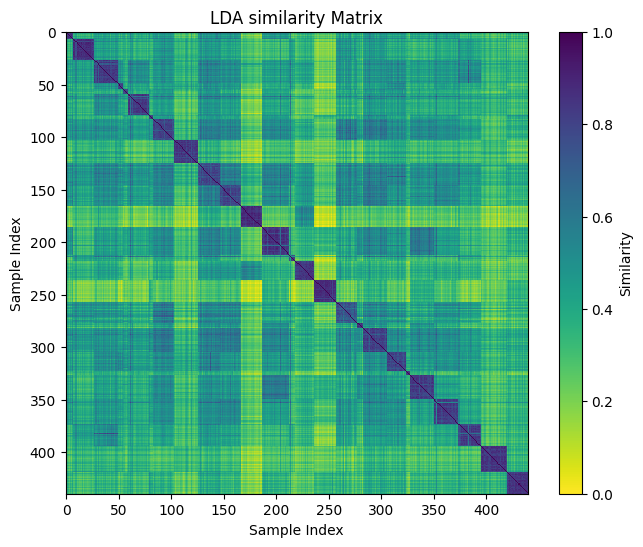

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow((np.max(pairwise_lda)-pairwise_lda)/np.max(pairwise_lda), cmap='viridis_r', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('LDA similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

In [ ]:
try:
    pairwise_lbp = np.load("pairwise_lbp.npy")
except:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp = desc.describe_list(faces.images[...,0])
    dist_metric = CHI2
    pairwise_lbp = calc_pairwise(embedded_lbp, dist_metric)
    np.save("pairwise_lbp.npy", pairwise_lbp)

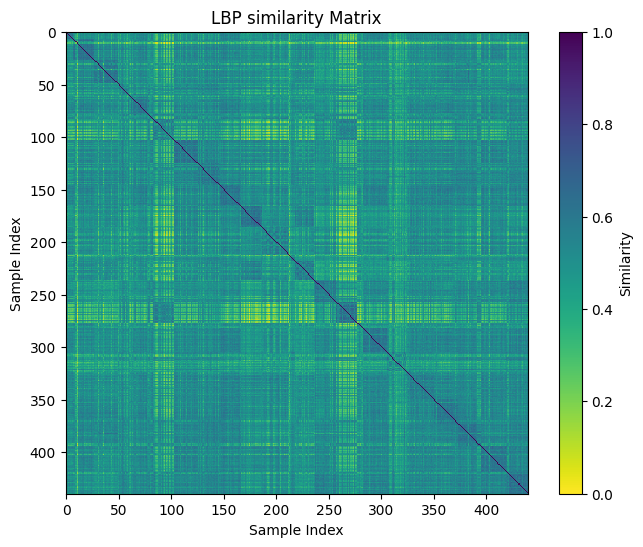

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow((np.max(pairwise_lbp)-pairwise_lbp)/np.max(pairwise_lbp), cmap='viridis_r', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('LBP similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

In [ ]:
try:
    pairwise_dl = np.load("pairwise_dl.npy")
except:
    dist_metric = euclidean
    pairwise_dl = calc_pairwise(embedded, dist_metric)
    np.save("pairwise_dl.npy", pairwise_dl)

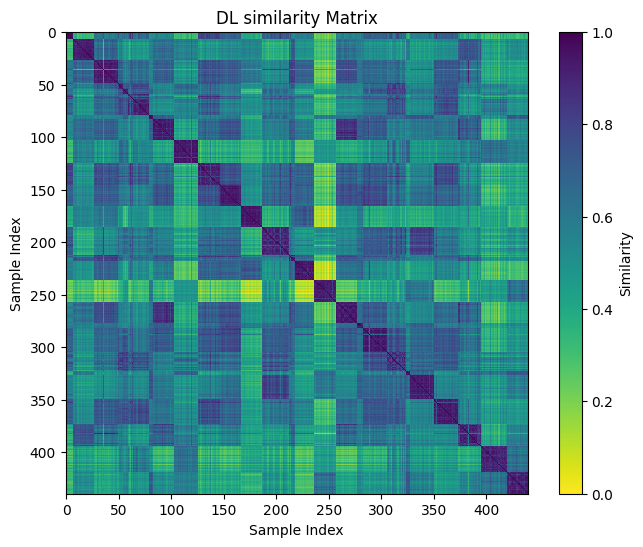

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow((np.max(pairwise_dl)-pairwise_dl)/np.max(pairwise_dl), cmap='viridis_r', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('DL similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

## 2. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1.

### 2.1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

In [ ]:
unique_labels = np.unique(faces["target"])

In [ ]:
# Normalize based on the highest non-zero element
# since the diagonal will be zero
def normalize_pairwise(pairwise):
    min = np.min(pairwise[pairwise > 0])
    return (pairwise - min) / (np.max(pairwise) - min)

# Get Dict showing Genuine and Impostors
def get_pairwise_dict(pairwise):
    rows, cols = pairwise.shape
    # Transform the NumPy array into a dictionary
    # With false everywhere
    result_dict = {(i, j): False for i in range(rows) for j in range(cols)}
    # Find correct Ids and set them to True
    for i in unique_labels:
            # Filter correct Ids
            true_ids = np.where(faces["target"] == i)[0]
            for x in true_ids:
                for y in true_ids:
                    result_dict[(x,y)] = True
    return result_dict

# Get scores.
def get_genuine_impostor(pairwise):
    genuine_scores = []
    impostor_scores = []
    for i in unique_labels:
        true_ids = np.where(faces["target"] == i)[0]
        for x in true_ids:
            for y in true_ids:
                # Look only in upper non-diagonal triangle for efficiency
                if x < y:
                  genuine_scores.append(pairwise[x,y])
        false_ids = np.where(faces["target"] != i)[0]
        for x in true_ids:
            for y in false_ids:
                if x < y:
                    impostor_scores.append(pairwise[x,y])
    return genuine_scores, impostor_scores

In [ ]:
pairwise_pca = normalize_pairwise(pairwise_pca)
pairwise_lda = normalize_pairwise(pairwise_lda)
pairwise_lbp = normalize_pairwise(pairwise_lbp)
pairwise_dl = normalize_pairwise(pairwise_dl)

In [ ]:
print(np.min(pairwise_pca))

-0.10360344482605224


In [ ]:
try:
    with open('dict_all.pkl', 'rb') as f:
      dict_all = pickle.load(f)
except:
    dict_all = get_pairwise_dict(pairwise_dl)
    with open('dict_all.pkl', 'wb') as f:
        pickle.dump(dict_all, f)

In [ ]:
try:
    with open("genuine_pca.pkl", 'rb') as f:
        genuine_pca = pickle.load(f)
    with open("impostor_pca.pkl", 'rb') as f:
        impostor_pca = pickle.load(f)
except:
    genuine_pca, impostor_pca = get_genuine_impostor(pairwise_pca)
    with open("genuine_pca.pkl", 'wb') as f:
        pickle.dump(genuine_pca, f)
    with open("impostor_pca.pkl", 'wb') as f:
        pickle.dump(impostor_pca, f)


try:
    with open("genuine_lda.pkl", 'rb') as f:
        genuine_lda = pickle.load(f)
    with open("impostor_lda.pkl", 'rb') as f:
        impostor_lda = pickle.load(f)
except:
    genuine_lda, impostor_lda = get_genuine_impostor(pairwise_lda)
    with open("genuine_lda.pkl", 'wb') as f:
        pickle.dump(genuine_lda, f)
    with open("impostor_lda.pkl", 'wb') as f:
        pickle.dump(impostor_lda, f)

try:
    with open("genuine_lbp.pkl", 'rb') as f:
        genuine_lbp = pickle.load(f)
    with open("impostor_lbp.pkl", 'rb') as f:
        impostor_lbp = pickle.load(f)
except:
    genuine_lbp, impostor_lbp = get_genuine_impostor(pairwise_lbp)
    with open("genuine_lbp.pkl", 'wb') as f:
        pickle.dump(genuine_lbp, f)
    with open("impostor_lbp.pkl", 'wb') as f:
        pickle.dump(impostor_lbp, f)


try:
    with open("genuine_dl.pkl", 'rb') as f:
        genuine_dl = pickle.load(f)
    with open("impostor_dl.pkl", 'rb') as f:
        impostor_dl = pickle.load(f)
except:
    genuine_dl, impostor_dl = get_genuine_impostor(pairwise_dl)
    with open("genuine_dl.pkl", 'wb') as f:
        pickle.dump(genuine_dl, f)
    with open("impostor_dl.pkl", 'wb') as f:
        pickle.dump(impostor_dl, f)

In [ ]:
systems = [("PCA", "skyblue", "--", genuine_pca, impostor_pca),
           ("LDA", "red", ":", genuine_lda, impostor_lda),
           ("LBP", "#D3C710", "--", genuine_lbp, impostor_lbp),
           ("DL", "black", ":", genuine_dl, impostor_dl)]

In [ ]:
np.array(genuine_pca).shape

(4210,)

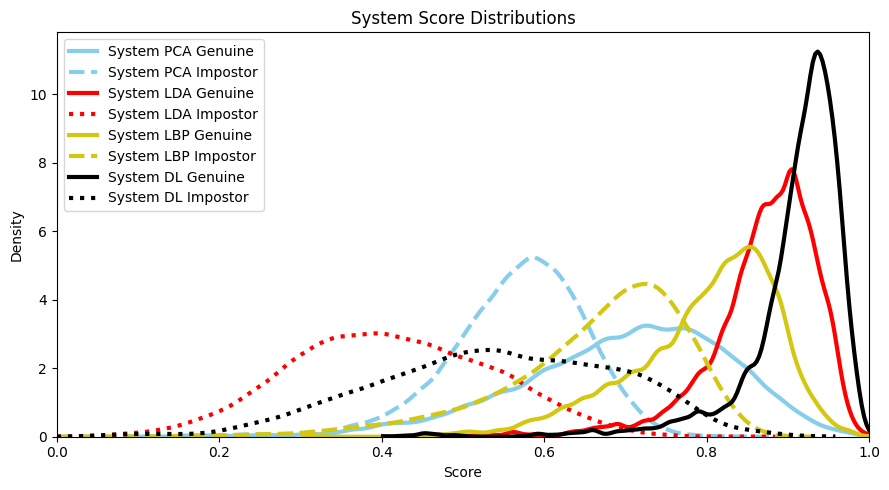

In [ ]:
"""Plot the genuine and imposter score distributions."""
# Seaborn for kde plotting
import seaborn as sns
# Define the figure size and layout
plt.figure(figsize=(9, 5))
# Loop through each system, creating a subplot for each
for i, (name, color, style, genuine_scores, impostor_scores) in enumerate(systems):
    # Plot KDEs for genuine and impostor scores
    sns.kdeplot(1-np.array(genuine_scores), label=f'System {name} Genuine', color=color, linewidth=3, bw_method=0.1, cut=0) # bw_method=0.1 for more details
    sns.kdeplot(1-np.array(impostor_scores), label=f'System {name} Impostor', color=color, bw_method=0.1, linewidth=3, linestyle=style, cut=0)
    # Add details
    plt.title('System Score Distributions')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(0, 1)
# This adjusts subplot params so that the subplots fit into the figure area.
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Q3: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

In [ ]:
# Calc TP, FN, FP, TN for every threhsold
def calculate_stats(pairwise, pairwise_dict, thresholds):
  # Initialize array for each TP, FP, FN, TN and each threshold
    stats_array = np.zeros((len(thresholds), 26, 4), dtype=np.float32)
    # For each threshold
    for thresh_idx, thresh in enumerate(thresholds):
        # For each img
        for i in range(pairwise.shape[0]):
            # get its comparative True Positives, False Negatives, False Positives, True Negatives
            TP = np.sum([pairwise[i, y] < thresh and pairwise_dict[(i, y)] == True for y in range(pairwise.shape[1])]) - 1 # to negate the comparison with itself
            FN = np.sum([pairwise[i, y] >= thresh and pairwise_dict[(i, y)] == True for y in range(pairwise.shape[1])])
            FP = np.sum([pairwise[i, y] < thresh and pairwise_dict[(i, y)] == False for y in range(pairwise.shape[1])])
            TN = np.sum([pairwise[i, y] >= thresh and pairwise_dict[(i, y)] == False for y in range(pairwise.shape[1])])
            # Get the label to append at the right place
            label = faces["target"][i]
            # Append at the correct label
            stats_array[thresh_idx, label, :] += np.array([TP, FP, FN, TN], dtype=np.float32)
    return stats_array

# Calc f1, precision, recall and accuracy
def f1_recall_precision_accuracy(stats_array):
    # Init arrays
    f1_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    recall_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    precision_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    acc_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    # For each threshold
    for thresh in range(stats_array.shape[0]):
        # For each img label
        for i in range(stats_array.shape[1]):
            # Get stats
            TP = stats_array[thresh, i, 0]
            FP = stats_array[thresh, i, 1]
            FN = stats_array[thresh, i, 2]
            TN = stats_array[thresh, i, 3]

            # Calc recall, precision, accurracy
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            accuracy = (TP + TN) / (TP + FN + TN + FP) if (TP + FN + TN + FP) > 0 else 0
            recall_array[thresh, i] = recall
            precision_array[thresh, i] = precision
            acc_array[thresh, i] = accuracy

            # Calc f1
            if precision == 0 and recall == 0:
                f1 = 0
            else:
                f1 = 2 * recall * precision / (recall + precision)
            f1_array[thresh, i] = f1

    # Find the mean for each threshold
    f1_meaned = np.mean(f1_array, axis=1)
    recall_meaned = np.mean(recall_array, axis=1)
    precision_meaned = np.mean(precision_array, axis=1)
    acc_meaned = np.mean(acc_array, axis=1)
    return f1_meaned, recall_meaned, precision_meaned, acc_meaned

In [ ]:
thresholds = np.linspace(0, 1, 100)

print("Creating pca stats")
try:
    stats_pca = np.load("stats_pca.npy")
    f1_pca = np.load("f1_pca.npy")
    recall_pca = np.load("recall_pca.npy")
    precision_pca = np.load("precision_pca.npy")
    acc_pca = np.load("acc_pca.npy")
except:
    stats_pca = calculate_stats(pairwise_pca, dict_all, thresholds)
    f1_pca, recall_pca, precision_pca , acc_pca = f1_recall_precision_accuracy(stats_pca)
    np.save("stats_pca.npy", stats_pca)
    np.save("f1_pca.npy", f1_pca)
    np.save("recall_pca.npy", recall_pca)
    np.save("precision_pca.npy", precision_pca)
    np.save("acc_pca.npy", acc_pca)
f_stats_pca = [f1_pca, recall_pca, precision_pca]

print("Creating lda stats")
try:
    stats_lda = np.load("stats_lda.npy")
    f1_lda = np.load("f1_lda.npy")
    recall_lda = np.load("recall_lda.npy")
    precision_lda = np.load("precision_lda.npy")
    acc_lda = np.load("acc_lda.npy")
except:
    stats_lda = calculate_stats(pairwise_lda, dict_all, thresholds)
    f1_lda, recall_lda, precision_lda , acc_lda = f1_recall_precision_accuracy(stats_lda)
    np.save("stats_lda.npy", stats_lda)
    np.save("f1_lda.npy", f1_lda)
    np.save("recall_lda.npy", recall_lda)
    np.save("precision_lda.npy", precision_lda)
    np.save("acc_lda.npy", acc_lda)
f_stats_lda = [f1_lda, recall_lda, precision_lda]

print("Creating lbp stats")
try:
    stats_lbp = np.load("stats_lbp.npy")
    f1_lbp = np.load("f1_lbp.npy")
    recall_lbp = np.load("recall_lbp.npy")
    precision_lbp = np.load("precision_lbp.npy")
    acc_lbp = np.load("acc_lbp.npy")
except:
    stats_lbp = calculate_stats(pairwise_lbp, dict_all, thresholds)
    f1_lbp, recall_lbp, precision_lbp , acc_lbp = f1_recall_precision_accuracy(stats_lbp)
    np.save("stats_lbp.npy", stats_lbp)
    np.save("f1_lbp.npy", f1_lbp)
    np.save("recall_lbp.npy", recall_lbp)
    np.save("precision_lbp.npy", precision_lbp)
    np.save("acc_lbp.npy", acc_lbp)
f_stats_lbp = [f1_lbp, recall_lbp, precision_lbp]

print("Creating dl stats")
try:
    stats_dl = np.load("stats_dl.npy")
    f1_dl = np.load("f1_dl.npy")
    recall_dl = np.load("recall_dl.npy")
    precision_dl = np.load("precision_dl.npy")
    acc_dl = np.load("acc_dl.npy")
except:
    stats_dl = calculate_stats(pairwise_dl, dict_all, thresholds)
    f1_dl, recall_dl, precision_dl , acc_dl = f1_recall_precision_accuracy(stats_dl)
    np.save("stats_dl.npy", stats_dl)
    np.save("f1_dl.npy", f1_dl)
    np.save("recall_dl.npy", recall_dl)
    np.save("precision_dl.npy", precision_dl)
    np.save("acc_dl.npy", acc_dl)
f_stats_dl = [f1_dl, recall_dl, precision_dl]

Creating pca stats
Creating lda stats
Creating lbp stats
Creating dl stats


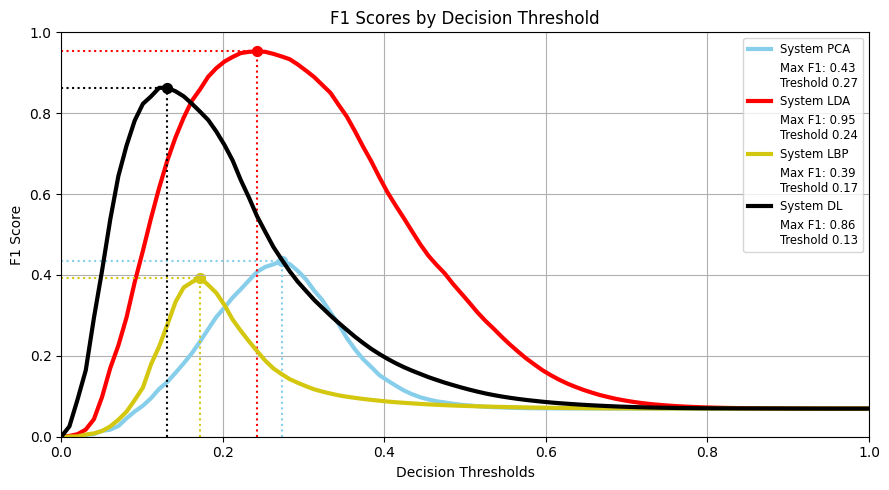

In [ ]:
# Create systems like in Assignment 1
systems = [("PCA", "skyblue", "-", f_stats_pca, stats_pca),
           ("LDA", "red", "-", f_stats_lda, stats_lda),
           ("LBP", "#D3C710", "-", f_stats_lbp, stats_lbp),
           ("DL", "black", "-", f_stats_dl, stats_dl)]


"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    # Get f1
    f1 = f_stat[0]
    # Get max f1 and its index to project lines
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f}\nTreshold {max_threshold:.2f}')
plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

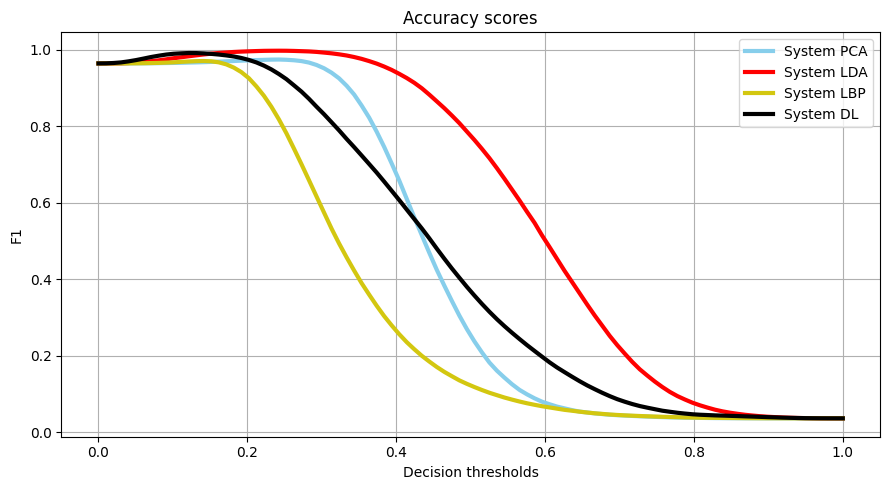

In [ ]:
systems = [("PCA", "skyblue", "--", acc_pca, stats_pca),
           ("LDA", "red", ":", acc_lda, stats_lda),
           ("LBP", "#D3C710", "--", acc_lbp, stats_lbp),
           ("DL", "black", ":", acc_dl, stats_dl)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, f_stat, _) in enumerate(systems):
    plt.plot(thresholds, f_stat, color=color, label=f'System {typeM}', linewidth=3)
    plt.title('Accuracy scores')
    plt.xlabel('Decision thresholds')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

In [ ]:
# Calculate tpr from the stats_array above
def calc_tpr_fpr_frr(stats_array):
    tpr_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    fpr_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    frr_array = np.zeros((stats_array.shape[0], stats_array.shape[1]), dtype=np.float32)
    for thresh in range(stats_array.shape[0]):
        for i in range(stats_array.shape[1]):
            TP = stats_array[thresh, i, 0]
            FP = stats_array[thresh, i, 1]
            FN = stats_array[thresh, i, 2]
            TN = stats_array[thresh, i, 3]

            tpr = TP/(TP+FN) if TP+FN>0 else 0
            fpr = FP/(FP+TN) if FP+TN>0 else 0
            frr = FN/(TP+FN) if TP+FN>0 else 0

            tpr_array[thresh, i] = tpr
            fpr_array[thresh, i] = fpr
            frr_array[thresh, i] = frr

    # Get the mean for each threshold
    tpr_meaned = np.mean(tpr_array, axis=1)
    fpr_meaned = np.mean(fpr_array, axis=1)
    frr_meaned = np.mean(frr_array, axis=1)
    return tpr_meaned, fpr_meaned, frr_meaned

In [ ]:
try:
    tpr_pca = np.load("tpr_pca.npy")
    fpr_pca = np.load("fpr_pca.npy")
    frr_pca = np.load("frr_pca.npy")
except:
    tpr_pca, fpr_pca, frr_pca = calc_tpr_fpr_frr(stats_pca)
    np.save("tpr_pca.npy", tpr_pca)
    np.save("fpr_pca.npy", fpr_pca)
    np.save("frr_pca.npy", frr_pca)
r_stats_pca = [tpr_pca, fpr_pca, frr_pca]



try:
    tpr_lda = np.load("tpr_lda.npy")
    fpr_lda = np.load("fpr_lda.npy")
    frr_lda = np.load("frr_lda.npy")
except:
    tpr_lda, fpr_lda, frr_lda = calc_tpr_fpr_frr(stats_lda)
    np.save("tpr_lda.npy", tpr_lda)
    np.save("fpr_lda.npy", fpr_lda)
    np.save("frr_lda.npy", frr_lda)
r_stats_lda = [tpr_lda, fpr_lda, frr_lda]



try:
    tpr_lbp = np.load("tpr_lbp.npy")
    fpr_lbp = np.load("fpr_lbp.npy")
    frr_lbp = np.load("frr_lbp.npy")
except:
    tpr_lbp, fpr_lbp, frr_lbp = calc_tpr_fpr_frr(stats_lbp)
    np.save("tpr_lbp.npy", tpr_lbp)
    np.save("fpr_lbp.npy", fpr_lbp)
    np.save("frr_lbp.npy", frr_lbp)
r_stats_lbp = [tpr_lbp, fpr_lbp, frr_lbp]



try:
    tpr_dl = np.load("tpr_dl.npy")
    fpr_dl = np.load("fpr_dl.npy")
    frr_dl = np.load("frr_dl.npy")
except:
    tpr_dl, fpr_dl, frr_dl = calc_tpr_fpr_frr(stats_dl)
    np.save("tpr_dl.npy", tpr_dl)
    np.save("fpr_dl.npy", fpr_dl)
    np.save("frr_dl.npy", frr_dl)
r_stats_dl = [tpr_dl, fpr_dl, frr_dl]

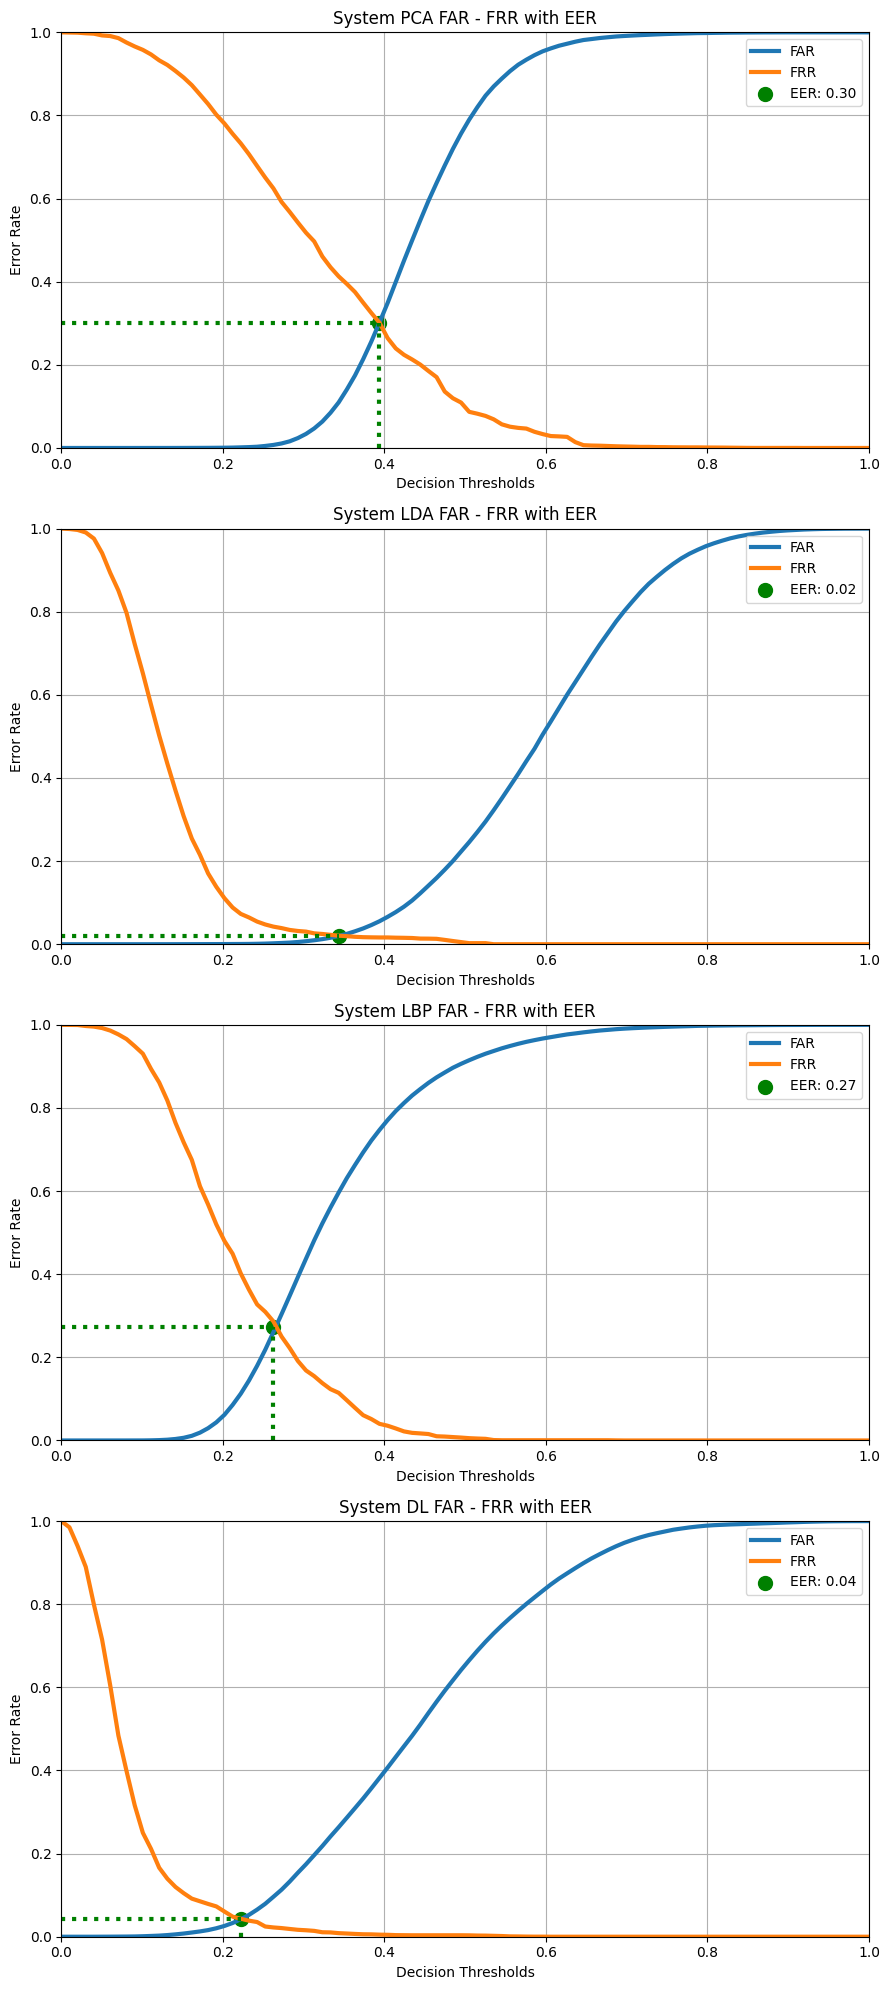

In [ ]:
systems = [("PCA", "skyblue", "--", f_stats_pca, r_stats_pca, stats_pca),
           ("LDA", "red", ":", f_stats_lda, r_stats_lda, stats_lda),
           ("LBP", "#D3C710", "--", f_stats_lbp, r_stats_lbp, stats_lbp),
           ("DL", "black", ":", f_stats_dl, r_stats_dl, stats_dl)]

"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
plt.figure(figsize=(9, 20))
for i, (typeM, color, mark, _, r_stats, _) in enumerate(systems):
    plt.subplot(4, 1, i+1)
     # Differences between FAR and FRR
    diffs = np.abs(r_stats[1] - r_stats[2])
    # Index of minimum difference
    minIdx = np.argmin(diffs)
    # Calculate EER as mean of two points
    EER = (r_stats[1][minIdx] + r_stats[2][minIdx]) / 2
    plt.plot(thresholds, r_stats[1], label='FAR', linewidth=3)
    plt.plot(thresholds, r_stats[2], label='FRR', linewidth=3)
    # Mark the EER point
    plt.scatter(thresholds[minIdx], EER, color='green', s=100, label=f'EER: {EER:.2f}')  # Mark EER
    plt.vlines(thresholds[minIdx], 0, EER, colors='green', linestyles='dotted', linewidth=3)  # Vertical line at EER
    plt.hlines(EER, 0, thresholds[minIdx], colors='green', linestyles='dotted', linewidth=3)  # Horizontal line at EER
    plt.title(f'System {typeM} FAR - FRR with EER')
    plt.xlabel('Decision Thresholds')
    plt.ylabel('Error Rate')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import auc

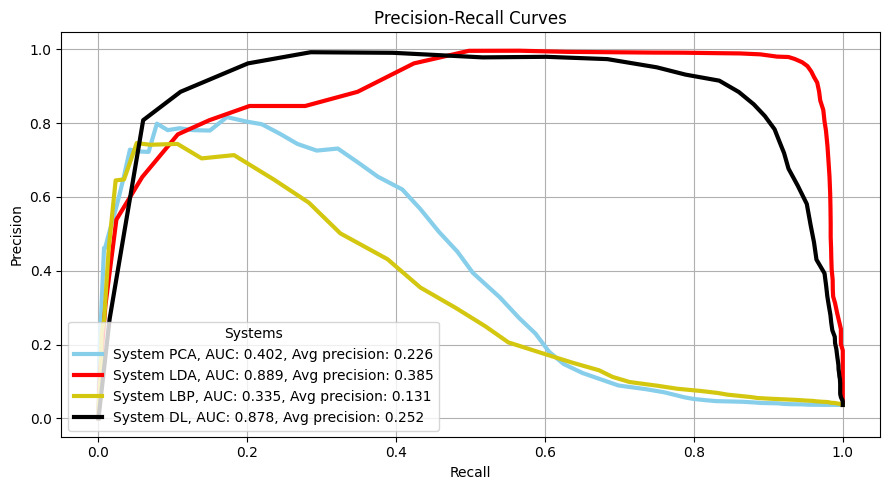

In [ ]:
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, f_stats, r_stats, stats) in enumerate(systems):
    # Get precision and recall
    precision = f_stats[2]
    recall = f_stats[1]
    """Calculate the Area Under the PR-curve."""
    area = auc(recall, precision)
    avg = np.mean(precision)
    plt.plot(recall, precision, label=f'System {typeM}, AUC: {area:.3f}, Avg precision: {avg:.3f}', color=color, linewidth=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves')
    plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.15), fontsize='medium', title='Systems')
plt.tight_layout()
plt.show()

### 2.2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario.
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [ ]:
def calc_CMC(pairwise, pairwise_dict, labels):
    # Get unique labels
    num_unique_labels, count = np.unique(labels, return_counts=True)
    # Initialize to count holder
    cmc_counts = np.zeros(len(num_unique_labels), dtype=int)
    # and sucesses for rank-1
    rank1_success = 0
    for i in range(pairwise.shape[0]):
        # Get similarity scores for the i-th query, ignoring self-comparison
        scores = 1-pairwise[i, :]
        # Set self-similarity to a very low value to exclude it from ranking
        scores[i] = -np.inf
        # Get indices of sorted scores in descending order
        indices = np.argsort(scores)[::-1]
        # Check if the top match is correct for Rank-1 accuracy
        if pairwise_dict[(i, indices[0])]:
            rank1_success += 1
        # Find the rank at which the first correct match occurs
        for rank, index in enumerate(indices):
            if pairwise_dict[(i, index)]:
                cmc_counts[rank:] += 1
                break
    # Convert cumulative counts to probabilities
    cmc_curve = cmc_counts / (pairwise.shape[0]-1)
    # Rank-1 accuracy as a fraction of total queries
    rank1_accuracy = rank1_success / (pairwise.shape[0]-1)
    return cmc_curve, rank1_accuracy

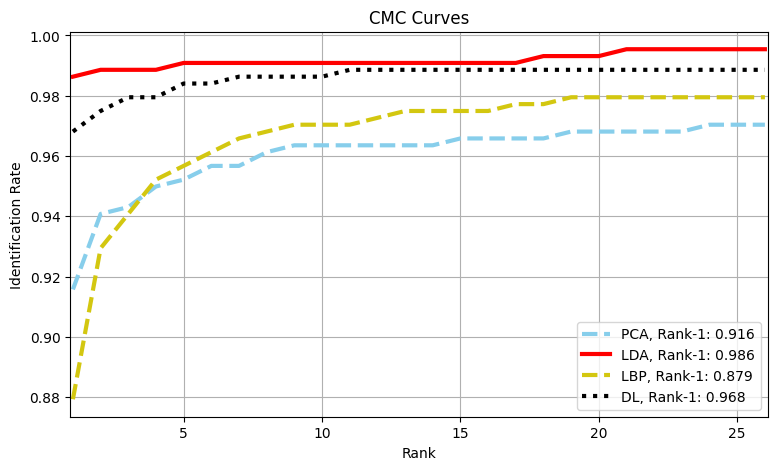

In [ ]:
systems_cmc = [("PCA", "skyblue", "--", pairwise_pca),
           ("LDA", "red", "solid", pairwise_lda),
           ("LBP", "#D3C710", "--", pairwise_lbp),
           ("DL", "black", ":", pairwise_dl)]

"""Calculate the Cumulative Matching Characteristic curve."""
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    # Calc CMC
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'{typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9,26.1)
    plt.grid(True)
    plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Q6: </b> Fine-tune your model for feature extraction
</div>

Hint: Tuning is the process of selecting the optimal values for a machine learning model's hyperparameters. For PCA, LDA and DL using Siamese Networks, assess the dimension of latent representations (num_components). For LBP, examine the radius. You can use default values for other parameters as provided. In your report, please explain the effect of these hyperparameters on model performance using 2 implemented evaluation metrics of your choice from Questions 3-5, and provide reasoning for their impact.

In [ ]:
try:
    pairwise_pca_5 = np.load("pairwise_pca_5.npy")
except:
    num_components = min(5, min(n_samples, n_features))
      desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    dist_metric = euclidean
    pairwise_pca_5 = calc_pairwise(embedded_pca, dist_metric)
    np.save("pairwise_pca_5.npy", pairwise_pca_5)

try:
    pairwise_pca_20 = np.load("pairwise_pca_20.npy")
except:
    num_components = min(20, min(n_samples, n_features))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    dist_metric = euclidean
    pairwise_pca_20 = calc_pairwise(embedded_pca, dist_metric)
    np.save("pairwise_pca_20.npy", pairwise_pca_20)

try:
    pairwise_pca_50 = np.load("pairwise_pca_50.npy")
except:
    num_components = min(50, min(n_samples, n_features))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    dist_metric = euclidean
    pairwise_pca_50 = calc_pairwise(embedded_pca, dist_metric)
    np.save("pairwise_pca_50.npy", pairwise_pca_50)


pairwise_pca_5 = normalize_pairwise(pairwise_pca_5)
pairwise_pca_20 = normalize_pairwise(pairwise_pca_20)
pairwise_pca_50 = normalize_pairwise(pairwise_pca_50)

num_components 5
num_components 20
num_components 50


In [ ]:
print("Creating pca_5 stats")
try:
    stats_pca_5 = np.load("stats_pca_5.npy")
    f1_pca_5 = np.load("f1_pca_5.npy")
    recall_pca_5 = np.load("recall_pca_5.npy")
    precision_pca_5 = np.load("precision_pca_5.npy")
except:
    stats_pca_5 = calculate_stats(pairwise_pca_5, dict_all, thresholds)
    f1_pca_5, recall_pca_5, precision_pca_5, _ = f1_recall_precision_accuracy(stats_pca_5)
    np.save("stats_pca_5.npy", stats_pca_5)
    np.save("f1_pca_5.npy", f1_pca_5)
    np.save("recall_pca_5.npy", recall_pca_5)
    np.save("precision_pca_5.npy", precision_pca_5)
f_stats_pca_5 = [f1_pca_5, recall_pca_5, precision_pca_5]

print("Creating pca_20 stats")
try:
    stats_pca_20 = np.load("stats_pca_20.npy")
    f1_pca_20 = np.load("f1_pca_20.npy")
    recall_pca_20 = np.load("recall_pca_20.npy")
    precision_pca_20 = np.load("precision_pca_20.npy")
except:
    stats_pca_20 = calculate_stats(pairwise_pca_20, dict_all, thresholds)
    f1_pca_20, recall_pca_20, precision_pca_20, _ = f1_recall_precision_accuracy(stats_pca_20)
    np.save("stats_pca_20.npy", stats_pca_20)
    np.save("f1_pca_20.npy", f1_pca_20)
    np.save("recall_pca_20.npy", recall_pca_20)
    np.save("precision_pca_20.npy", precision_pca_20)
f_stats_pca_20 = [f1_pca_20, recall_pca_20, precision_pca_20]

print("Creating pca_50 stats")
try:
    stats_pca_50 = np.load("stats_pca_50.npy")
    f1_pca_50 = np.load("f1_pca_50.npy")
    recall_pca_50 = np.load("recall_pca_50.npy")
    precision_pca_50 = np.load("precision_pca_50.npy")
except:
    stats_pca_50 = calculate_stats(pairwise_pca_50, dict_all, thresholds)
    f1_pca_50, recall_pca_50, precision_pca_50, _ = f1_recall_precision_accuracy(stats_pca_50)
    np.save("stats_pca_50.npy", stats_pca_50)
    np.save("f1_pca_50.npy", f1_pca_50)
    np.save("recall_pca_50.npy", recall_pca_50)
    np.save("precision_pca_50.npy", precision_pca_50)
f_stats_pca_50 = [f1_pca_50, recall_pca_50, precision_pca_50]

Creating pca_5 stats
Creating pca_20 stats
Creating pca_50 stats


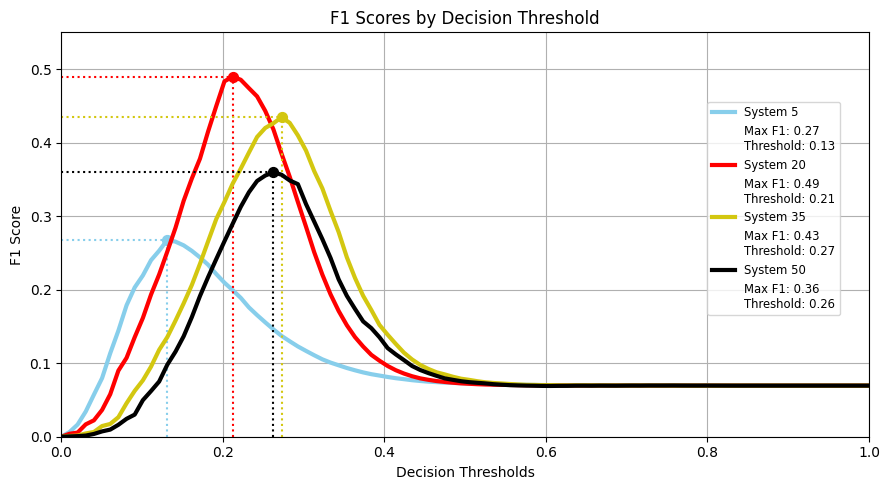

In [ ]:
systems = [("5", "skyblue", "-", f_stats_pca_5, stats_pca_5),
           ("20", "red", "-", f_stats_pca_20, stats_pca_20),
           ("35", "#D3C710", "-", f_stats_pca, stats_pca),
           ("50", "black", "-", f_stats_pca_50, stats_pca_50)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f} \nThreshold: {max_threshold:.2f}')

plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0, 1)
plt.ylim(0,0.55)
plt.legend(loc=[0.8,0.3], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

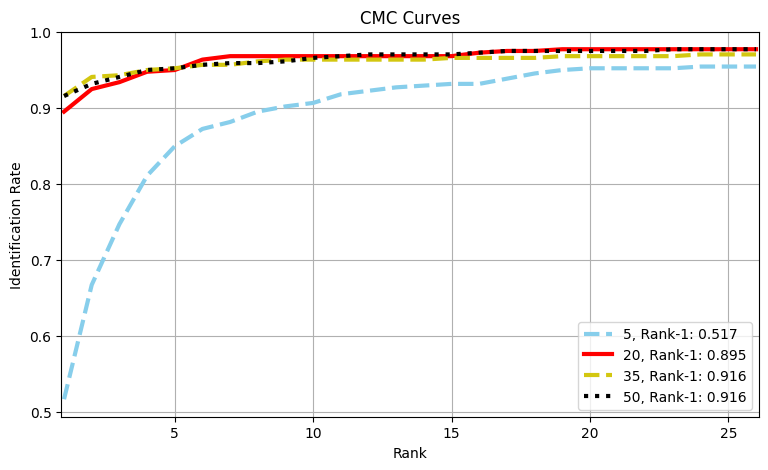

In [ ]:
systems_cmc = [("5", "skyblue", "--", pairwise_pca_5),
           ("20", "red", "solid", pairwise_pca_20),
           ("35", "#D3C710", "--", pairwise_pca),
           ("50", "black", ":", pairwise_pca_50)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'{typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9,26.1)
    plt.grid(True)
    plt.legend()
plt.show()

In [ ]:
try:
    pairwise_lda_5 = np.load("pairwise_lda_5.npy")
except:
    num_components = 5
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    dist_metric = euclidean
    pairwise_lda_5 = calc_pairwise(embedded_lda, dist_metric)
    np.save("pairwise_lda_5.npy", pairwise_lda_5)

try:
    pairwise_lda_15 = np.load("pairwise_lda_15.npy")
except:
    num_components = 15
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    dist_metric = euclidean
    pairwise_lda_15 = calc_pairwise(embedded_lda, dist_metric)
    np.save("pairwise_lda_15.npy", pairwise_lda_15)


pairwise_lda_5 = normalize_pairwise(pairwise_lda_5)
pairwise_lda_15 = normalize_pairwise(pairwise_lda_15)

In [ ]:
try:
    with open('dict_lda_5.pkl', 'rb') as f:
      dict_lda_5 = pickle.load(f)
except:
    dict_lda_5 = get_pairwise_dict(pairwise_lda_5)
    with open('dict_lda_5.pkl', 'wb') as f:
        pickle.dump(dict_lda_5, f)

try:
    with open('dict_lda_15.pkl', 'rb') as f:
      dict_lda_15 = pickle.load(f)
except:
    dict_lda_15 = get_pairwise_dict(pairwise_lda_15)
    with open('dict_lda_15.pkl', 'wb') as f:
        pickle.dump(dict_lda_15, f)

In [ ]:
print("Creating lda_5 stats")
try:
    stats_lda_5 = np.load("stats_lda_5.npy")
    f1_lda_5 = np.load("f1_lda_5.npy")
    recall_lda_5 = np.load("recall_lda_5.npy")
    precision_lda_5 = np.load("precision_lda_5.npy")
except:
    stats_lda_5 = calculate_stats(pairwise_lda_5, dict_lda_5, thresholds)
    f1_lda_5, recall_lda_5, precision_lda_5, _ = f1_recall_precision_accuracy(stats_lda_5)
    np.save("stats_lda_5.npy", stats_lda_5)
    np.save("f1_lda_5.npy", f1_lda_5)
    np.save("recall_lda_5.npy", recall_lda_5)
    np.save("precision_lda_5.npy", precision_lda_5)
f_stats_lda_5 = [f1_lda_5, recall_lda_5, precision_lda_5]

print("Creating lda_15 stats")
try:
    stats_lda_15 = np.load("stats_lda_15.npy")
    f1_lda_15 = np.load("f1_lda_15.npy")
    recall_lda_15 = np.load("recall_lda_15.npy")
    precision_lda_15 = np.load("precision_lda_15.npy")
except:
    stats_lda_15 = calculate_stats(pairwise_lda_15, dict_lda_15, thresholds)
    f1_lda_15, recall_lda_15, precision_lda_15, _ = f1_recall_precision_accuracy(stats_lda_15)
    np.save("stats_lda_15.npy", stats_lda_15)
    np.save("f1_lda_15.npy", f1_lda_15)
    np.save("recall_lda_15.npy", recall_lda_15)
    np.save("precision_lda_15.npy", precision_lda_15)
f_stats_lda_15 = [f1_lda_15, recall_lda_15, precision_lda_15]

Creating lda_5 stats
Creating lda_15 stats


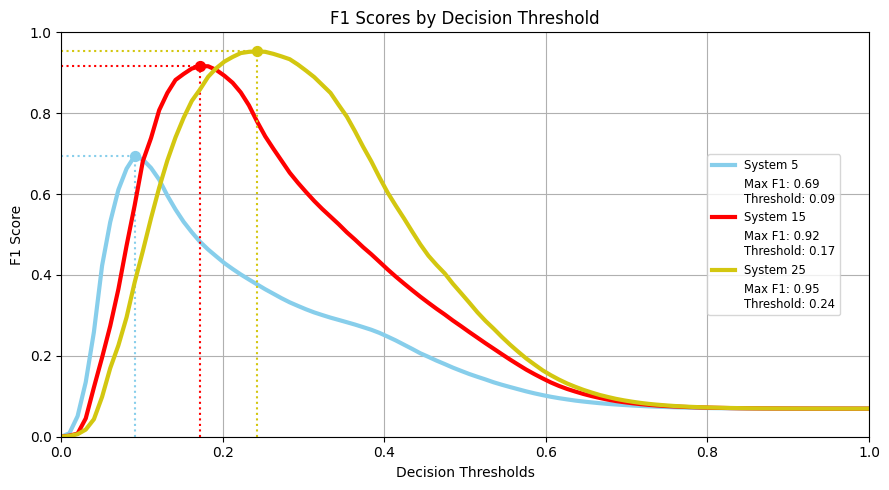

In [ ]:
systems = [("5", "skyblue", "-", f_stats_lda_5, stats_lda_5),
           ("15", "red", "-", f_stats_lda_15, stats_lda_15),
           ("25", "#D3C710", "-", f_stats_lda, stats_lda)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f} \nThreshold: {max_threshold:.2f}')

plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=[0.8,0.3], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

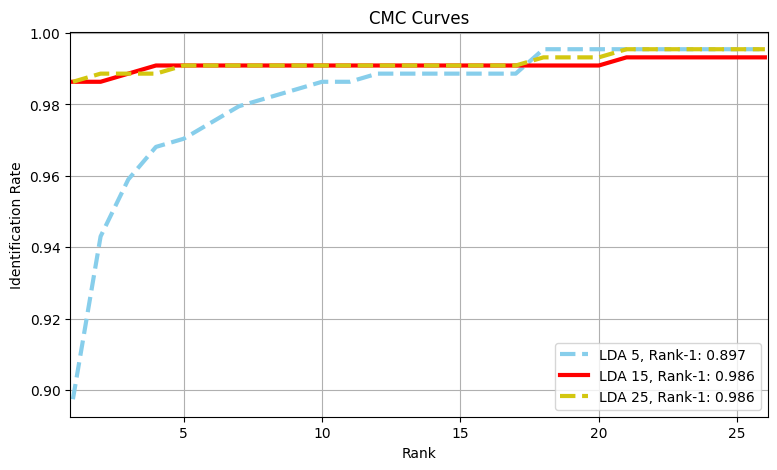

In [ ]:
systems_cmc = [("5", "skyblue", "--", pairwise_lda_5),
           ("15", "red", "solid", pairwise_lda_15),
           ("25", "#D3C710", "--", pairwise_lda)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'LDA {typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9, 26.1)
    plt.grid(True)
    plt.legend()
plt.show()

In [ ]:
try:
    pairwise_lbp_10 = np.load("pairwise_lbp_10.npy")
except:
    radius=10
    desc = LBP(numPoints=8, radius=radius, grid_x=7, grid_y=7)
    embedded_lbp_10 = desc.describe_list(faces.images[...,0])
    dist_metric = CHI2
    pairwise_lbp_10 = calc_pairwise(embedded_lbp_10, dist_metric)
    np.save("pairwise_lbp_10.npy", pairwise_lbp_10)


try:
    pairwise_lbp_7 = np.load("pairwise_lbp_7.npy")
except:
    radius=7
    desc = LBP(numPoints=8, radius=radius, grid_x=7, grid_y=7)
    embedded_lbp_7 = desc.describe_list(faces.images[...,0])
    dist_metric = CHI2
    pairwise_lbp_7 = calc_pairwise(embedded_lbp_7, dist_metric)
    np.save("pairwise_lbp_7.npy", pairwise_lbp_7)


try:
    pairwise_lbp_4 = np.load("pairwise_lbp_4.npy")
except:
    radius=4
    desc = LBP(numPoints=8, radius=radius, grid_x=7, grid_y=7)
    embedded_lbp_4 = desc.describe_list(faces.images[...,0])
    dist_metric = CHI2
    pairwise_lbp_4 = calc_pairwise(embedded_lbp_4, dist_metric)
    np.save("pairwise_lbp_4.npy", pairwise_lbp_4)

pairwise_lbp_4 = normalize_pairwise(pairwise_lbp_4)
pairwise_lbp_7 = normalize_pairwise(pairwise_lbp_7)
pairwise_lbp_10 = normalize_pairwise(pairwise_lbp_10)

In [ ]:
np.max(pairwise_lbp_10)

1.0

In [ ]:
print("Creating lbp_10 stats")
try:
    stats_lbp_10 = np.load("stats_lbp_10.npy")
    f1_lbp_10 = np.load("f1_lbp_10.npy")
    recall_lbp_10 = np.load("recall_lbp_10.npy")
    precision_lbp_10 = np.load("precision_lbp_10.npy")
except:
    stats_lbp_10 = calculate_stats(pairwise_lbp_10, dict_all, thresholds)
    f1_lbp_10, recall_lbp_10, precision_lbp_10, _ = f1_recall_precision_accuracy(stats_lbp_10)
    np.save("stats_lbp_10.npy", stats_lbp_10)
    np.save("f1_lbp_10.npy", f1_lbp_10)
    np.save("recall_lbp_10.npy", recall_lbp_10)
    np.save("precision_lbp_10.npy", precision_lbp_10)
f_stats_lbp_10 = [f1_lbp_10, recall_lbp_10, precision_lbp_10]

print("Creating lbp_7 stats")
try:
    stats_lbp_7 = np.load("stats_lbp_7.npy")
    f1_lbp_7 = np.load("f1_lbp_7.npy")
    recall_lbp_7 = np.load("recall_lbp_7.npy")
    precision_lbp_7 = np.load("precision_lbp_7.npy")
except:
    stats_lbp_7 = calculate_stats(pairwise_lbp_7, dict_all, thresholds)
    f1_lbp_7, recall_lbp_7, precision_lbp_7, _ = f1_recall_precision_accuracy(stats_lbp_7)
    np.save("stats_lbp_7.npy", stats_lbp_7)
    np.save("f1_lbp_7.npy", f1_lbp_7)
    np.save("recall_lbp_7.npy", recall_lbp_7)
    np.save("precision_lbp_7.npy", precision_lbp_7)
f_stats_lbp_7 = [f1_lbp_7, recall_lbp_7, precision_lbp_7]

print("Creating lbp_4 stats")
try:
    stats_lbp_4 = np.load("stats_lbp_4.npy")
    f1_lbp_4 = np.load("f1_lbp_4.npy")
    recall_lbp_4 = np.load("recall_lbp_4.npy")
    precision_lbp_4 = np.load("precision_lbp_4.npy")
except:
    stats_lbp_4 = calculate_stats(pairwise_lbp_4, dict_all, thresholds)
    f1_lbp_4, recall_lbp_4, precision_lbp_4, _ = f1_recall_precision_accuracy(stats_lbp_4)
    np.save("stats_lbp_4.npy", stats_lbp_4)
    np.save("f1_lbp_4.npy", f1_lbp_4)
    np.save("recall_lbp_4.npy", recall_lbp_4)
    np.save("precision_lbp_4.npy", precision_lbp_4)
f_stats_lbp_4 = [f1_lbp_4, recall_lbp_4, precision_lbp_4]

Creating lbp_10 stats
Creating lbp_7 stats
Creating lbp_4 stats


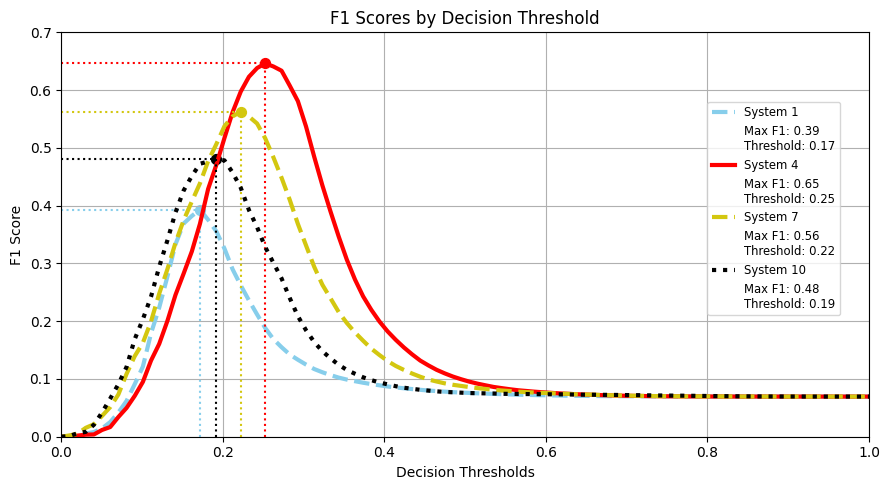

In [ ]:
systems = [("1", "skyblue", "--", f_stats_lbp, stats_lbp),
           ("4", "red", "solid", f_stats_lbp_4, stats_lbp_4),
           ("7", "#D3C710", "--", f_stats_lbp_7, stats_lbp_7),
           ("10", "black", ":", f_stats_lbp_10, stats_lbp_10)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f} \nThreshold: {max_threshold:.2f}')
plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,1)
plt.ylim(0,0.7)
plt.legend(loc=[0.8,0.3], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

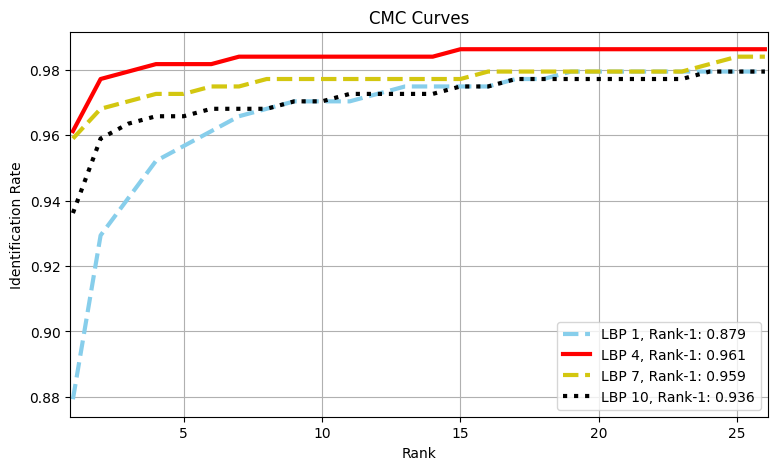

In [ ]:
systems_cmc = [("1", "skyblue", "--", pairwise_lbp),
           ("4", "red", "solid", pairwise_lbp_4),
           ("7", "#D3C710", "--", pairwise_lbp_7),
               ("10", "black", ":", pairwise_lbp_10)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'LBP {typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9, 26.1)
    plt.grid(True)
    plt.legend()
plt.show()

In [ ]:
encoder, model = siamese.create_siamese_model(imshape, 16)
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

epochs = 10
model_checkpoint = ModelCheckpoint('best_siamese_16.h5',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)

# Check if the weights file exists
if os.path.exists('best_siamese_16.h5'):
    # Load the weights if the file exists
    model.load_weights('best_siamese_16.h5')
    print("Weights loaded from 'best_siamese_16.h5'")
else:
    # Train the model if the weights file doesn't exist
    model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs,
              callbacks=[model_checkpoint])

# Evaluate the model on the test set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_16 = encoder(faces.images.astype(np.float32)).numpy()

dist_metric = euclidean

Weights loaded from 'best_siamese_16.h5'
16/16 [==============================] - 1s 31ms/step
Accuracy on the test set: 0.986


In [ ]:
encoder, model = siamese.create_siamese_model(imshape, 64)
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

epochs = 10
model_checkpoint = ModelCheckpoint('best_siamese_64.h5',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)
# Check if the weights file exists
if os.path.exists('best_siamese_64.h5'):
    # Load the weights if the file exists
    model.load_weights('best_siamese_64.h5')
    print("Weights loaded from 'best_siamese_64.h5'")
else:
    # Train the model if the weights file doesn't exist
    model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs,
              callbacks=[model_checkpoint])

# Evaluate the model on the test set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_64 = encoder(faces.images.astype(np.float32)).numpy()

dist_metric = euclidean

Weights loaded from 'best_siamese_64.h5'
16/16 [==============================] - 1s 32ms/step
Accuracy on the test set: 0.99


In [ ]:
encoder, model = siamese.create_siamese_model(imshape, 128)
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

epochs = 10
model_checkpoint = ModelCheckpoint('best_siamese_128.h5',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)

# Check if the weights file exists
if os.path.exists('best_siamese_128.h5'):
    # Load the weights if the file exists
    model.load_weights('best_siamese_128.h5')
    print("Weights loaded from 'best_siamese_128.h5'")
else:
    # Train the model if the weights file doesn't exist
    model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs,
              callbacks=[model_checkpoint])

# Evaluate the model on the test set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_128 = encoder(faces.images.astype(np.float32)).numpy()

dist_metric = euclidean

Weights loaded from 'best_siamese_128.h5'
16/16 [==============================] - 1s 32ms/step
Accuracy on the test set: 0.992


In [ ]:
try:
    pairwise_dl_16 = np.load("pairwise_dl_16.npy")
except:
    pairwise_dl_16 = calc_pairwise(embedded_16, dist_metric)
    np.save("pairwise_dl_16.npy", pairwise_dl_16)

try:
    pairwise_dl_64 = np.load("pairwise_dl_64.npy")
except:
    pairwise_dl_64 = calc_pairwise(embedded_64, dist_metric)
    np.save("pairwise_dl_64.npy", pairwise_dl_64)


try:
    pairwise_dl_128 = np.load("pairwise_dl_128.npy")
except:
    pairwise_dl_128 = calc_pairwise(embedded_128, dist_metric)
    np.save("pairwise_dl_128.npy", pairwise_dl_128)

pairwise_dl_16 = normalize_pairwise(pairwise_dl_16)
pairwise_dl_64 = normalize_pairwise(pairwise_dl_64)
pairwise_dl_128 = normalize_pairwise(pairwise_dl_128)

In [ ]:
print("Creating dl_16 stats")
try:
    stats_dl_16 = np.load("stats_dl_16.npy")
    f1_dl_16 = np.load("f1_dl_16.npy")
    recall_dl_16 = np.load("recall_dl_16.npy")
    precision_dl_16 = np.load("precision_dl_16.npy")
except:
    stats_dl_16 = calculate_stats(pairwise_dl_16, dict_all, thresholds)
    f1_dl_16, recall_dl_16, precision_dl_16, _ = f1_recall_precision_accuracy(stats_dl_16)
    np.save("stats_dl_16.npy", stats_dl_16)
    np.save("f1_dl_16.npy", f1_dl_16)
    np.save("recall_dl_16.npy", recall_dl_16)
    np.save("precision_dl_16.npy", precision_dl_16)
f_stats_dl_16 = [f1_dl_16, recall_dl_16, precision_dl_16]

print("Creating dl_64 stats")
try:
    stats_dl_64 = np.load("stats_dl_64.npy")
    f1_dl_64 = np.load("f1_dl_64.npy")
    recall_dl_64 = np.load("recall_dl_64.npy")
    precision_dl_64 = np.load("precision_dl_64.npy")
except:
    stats_dl_64 = calculate_stats(pairwise_dl_64, dict_all, thresholds)
    f1_dl_64, recall_dl_64, precision_dl_64, _ = f1_recall_precision_accuracy(stats_dl_64)
    np.save("stats_dl_64.npy", stats_dl_64)
    np.save("f1_dl_64.npy", f1_dl_64)
    np.save("recall_dl_64.npy", recall_dl_64)
    np.save("precision_dl_64.npy", precision_dl_64)
f_stats_dl_64 = [f1_dl_64, recall_dl_64, precision_dl_64]

print("Creating dl_128 stats")
try:
    stats_dl_128 = np.load("stats_dl_128.npy")
    f1_dl_128 = np.load("f1_dl_128.npy")
    recall_dl_128 = np.load("recall_dl_128.npy")
    precision_dl_128 = np.load("precision_dl_128.npy")
except:
    stats_dl_128 = calculate_stats(pairwise_dl_128, dict_all, thresholds)
    f1_dl_128, recall_dl_128, precision_dl_128, _ = f1_recall_precision_accuracy(stats_dl_128)
    np.save("stats_dl_128.npy", stats_dl_128)
    np.save("f1_dl_128.npy", f1_dl_128)
    np.save("recall_dl_128.npy", recall_dl_128)
    np.save("precision_dl_128.npy", precision_dl_128)
f_stats_dl_128 = [f1_dl_128, recall_dl_128, precision_dl_128]

Creating dl_16 stats
Creating dl_64 stats
Creating dl_128 stats


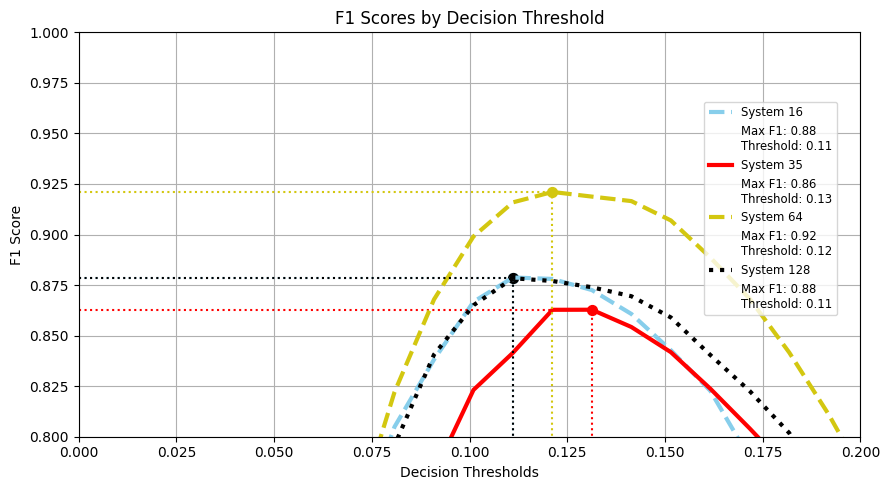

In [ ]:
systems = [("16", "skyblue", "--", f_stats_dl_16, stats_dl_16),
           ("35", "red", "solid", f_stats_dl, stats_dl),
           ("64", "#D3C710", "--", f_stats_dl_64, stats_dl_64),
           ("128", "black", ":", f_stats_dl_128, stats_dl_128)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f} \nThreshold: {max_threshold:.2f}')

plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.legend(loc=[0.8,0.3], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

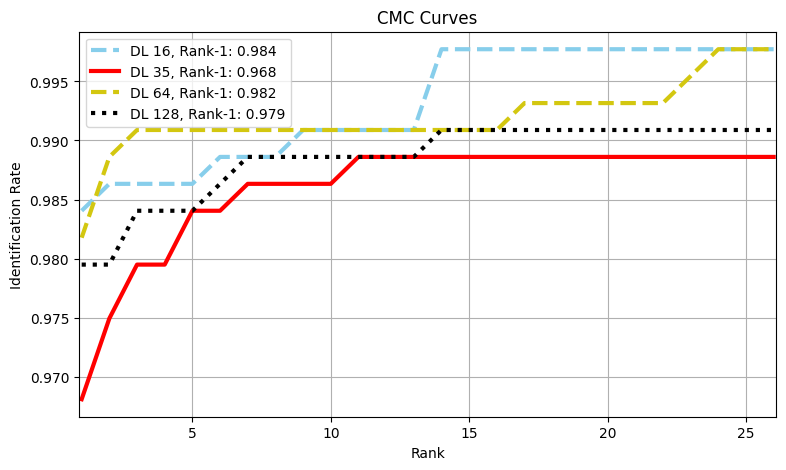

In [ ]:
systems_cmc = [("16", "skyblue", "--", pairwise_dl_16, dict_dl_16),
           ("35", "red", "solid", pairwise_dl, dict_dl),
           ("64", "#D3C710", "--", pairwise_dl_64, dict_dl_64),
               ("128", "black", ":", pairwise_dl_128, dict_dl_128)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim, dict_type) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_type, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'DL {typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9, 26.1)
    plt.grid(True)
    plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Q7: </b> Compare the 4 feature extraction models (LBP, PCA, LDA, DL using Siamese Networks)
</div>

Hint: Report on the performance using the implemented evaluation metrics from Questions 2-5. Perform the comparison among models under optimal hyperparameter settings as determined in Question 6

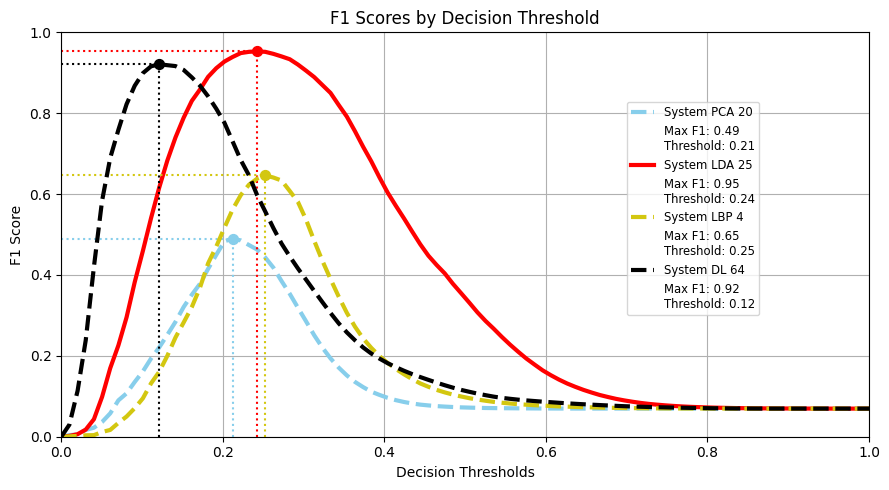

In [ ]:
systems = [("PCA 20", "skyblue", "--", f_stats_pca_20, stats_pca_20),
           ("LDA 25", "red", "solid", f_stats_lda, stats_lda),
           ("LBP 4", "#D3C710", "--", f_stats_lbp_4, stats_lbp_4),
           ("DL 64", "black", "--", f_stats_dl_64, stats_dl_64)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'System {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f} \nThreshold: {max_threshold:.2f}')

plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=[0.7,0.3], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

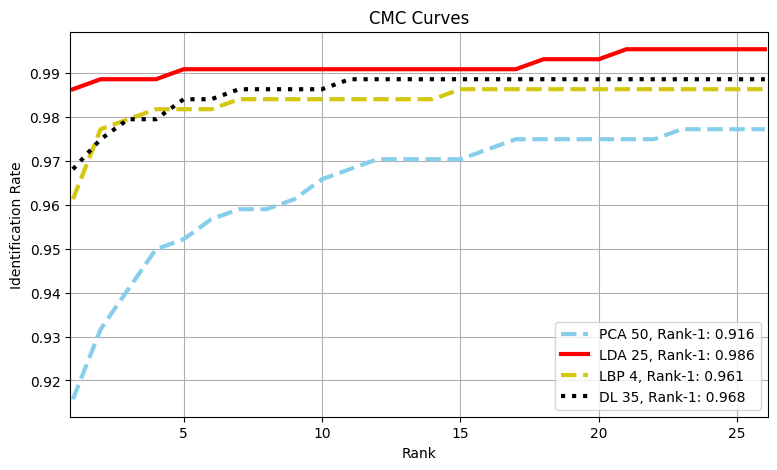

In [ ]:
systems_cmc = [("PCA 50", "skyblue", "--", pairwise_pca_50),
           ("LDA 25", "red", "solid", pairwise_lda),
           ("LBP 4", "#D3C710", "--", pairwise_lbp_4),
           ("DL 35", "black", ":", pairwise_dl)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'{typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9, 26.1)
    plt.grid(True)
    plt.legend()
plt.show()

## V. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>.

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section 'Distance-based and classification-based scoring') (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.)
6. Implement a different deep learning model* (3pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3.

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

In [ ]:
import importlib
importlib.reload(siamese)

<module 'localmodules.siamese' from '/content/Assignment3/localmodules/siamese.py'>

In [ ]:
encoder, model = siamese.create_siamese_model2(imshape, 64)
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

epochs = 20
model_checkpoint = ModelCheckpoint('best_siamese_se_64.keras',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)


# Check if the weights file exists
if os.path.exists('best_siamese_se_64.keras'):
    # Load the weights if the file exists
    model.load_weights('best_siamese_se_64.keras')
    print("Weights loaded from 'best_siamese_se_64.keras'")
else:
    # Train the model if the weights file doesn't exist
    history =  model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs,
              callbacks=[model_checkpoint])

# Evaluate the model on the test set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_se_64 = encoder(faces.images.astype(np.float32)).numpy()

dist_metric = euclidean

Weights loaded from 'best_siamese_se_64.keras'
16/16 [==============================] - 1s 46ms/step
Accuracy on the test set: 0.994


In [ ]:
encoder, model = siamese.create_siamese_model2(imshape, 35)
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics=[siamese.accuracy],
        run_eagerly=True)

epochs = 20
model_checkpoint = ModelCheckpoint('best_siamese_se_35.keras',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)


# Check if the weights file exists
if os.path.exists('best_siamese_se_35.keras'):
    # Load the weights if the file exists
    model.load_weights('best_siamese_se_35.keras')
    print("Weights loaded from 'best_siamese_se_35.keras'")
else:
    # Train the model if the weights file doesn't exist
    history =  model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs,
              callbacks=[model_checkpoint])

# Evaluate the model on the test set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_se_35 = encoder(faces.images.astype(np.float32)).numpy()

dist_metric = euclidean

Weights loaded from 'best_siamese_se_35.keras'
16/16 [==============================] - 1s 45ms/step
Accuracy on the test set: 1.0


In [ ]:
try:
    pairwise_dl_se_64 = np.load("pairwise_dl_se_64.npy")
except:
    pairwise_dl_se_64 = calc_pairwise(embedded_se_64, dist_metric)
    np.save("pairwise_dl_se_64.npy", pairwise_dl_se_64)

try:
    pairwise_dl_se_35 = np.load("pairwise_dl_se_35.npy")
except:
    pairwise_dl_se_35 = calc_pairwise(embedded_se_35, dist_metric)
    np.save("pairwise_dl_se_35.npy", pairwise_dl_se_35)


pairwise_dl_se_64= normalize_pairwise(pairwise_dl_se_64)
pairwise_dl_se_35 = normalize_pairwise(pairwise_dl_se_35)

In [ ]:
print("Creating dl_se_64 stats")
try:
    stats_dl_se_64 = np.load("stats_dl_se_64.npy")
    f1_dl_se_64 = np.load("f1_dl_se_64.npy")
    recall_dl_se_64 = np.load("recall_dl_se_64.npy")
    precision_dl_se_64 = np.load("precision_dl_se_64.npy")
except:
    stats_dl_se_64 = calculate_stats(pairwise_dl_se_64, dict_all, thresholds)
    f1_dl_se_64, recall_dl_se_64, precision_dl_se_64, _ = f1_recall_precision_accuracy(stats_dl_se_64)
    np.save("stats_dl_se_64.npy", stats_dl_se_64)
    np.save("f1_dl_se_64.npy", f1_dl_se_64)
    np.save("recall_dl_se_64.npy", recall_dl_se_64)
    np.save("precision_dl_se_64.npy", precision_dl_se_64)
f_stats_dl_se_64 = [f1_dl_se_64, recall_dl_se_64, precision_dl_se_64]

print("Creating dl_se_35 stats")
try:
    stats_dl_mine = np.load("stats_dl_se_35.npy")
    f1_dl_se_35 = np.load("f1_dl_se_35.npy")
    recall_dl_se_35 = np.load("recall_dl_se_35.npy")
    precision_dl_se_35 = np.load("precision_dl_se_35.npy")
except:
    stats_dl_se_35 = calculate_stats(pairwise_dl_se_35, dict_all, thresholds)
    f1_dl_se_35, recall_dl_se_35, precision_dl_se_35, _ = f1_recall_precision_accuracy(stats_dl_se_35)
    np.save("stats_dl_se_35.npy", stats_dl_se_35)
    np.save("f1_dl_se_35.npy", f1_dl_se_35)
    np.save("recall_dl_se_35.npy", recall_dl_se_35)
    np.save("precision_dl_se_35.npy", precision_dl_se_35)
f_stats_dl_se_35 = [f1_dl_se_35, recall_dl_se_35, precision_dl_se_35]

Creating dl_se_64 stats
Creating dl_se_35 stats


# ViT

In [1278]:
from tensorflow.keras import layers

# Positional Embedding Layer
class PosEmbedding(layers.Layer):
    def __init__(self, patch_size, emb_dim):
      super().__init__()
      # Einstein Notation
      self.patcher = Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
      # embeddings per patch
      self.emb_dim = emb_dim
      # Patch size
      self.patch_size = patch_size
      self.init = initializers.RandomNormal()

    def build(self, inp_dim):
      num_patches = (inp_dim[1]//self.patch_size) * (inp_dim[2]//self.patch_size)
      dim = self.patch_size * self.patch_size * inp_dim[-1] # p1 * p2 * c
      # Create embeddings
      self.dense = EinMix('b np d -> b np e', weight_shape='d e', d=dim, e=self.emb_dim)
      self.pos_embedding = tf.Variable(self.init((1, num_patches+1, self.emb_dim)), trainable=True)
      # Token for input ending
      self.cls_token = tf.Variable(self.init((1, 1, self.emb_dim)), trainable=True)

    def call(self, x, training=False):
      cls_token = tf.repeat(self.cls_token, tf.shape(x)[0], 0)
      x = self.dense(self.patcher(x), training=training)
      x = tf.concat([cls_token, x], axis=1)
      return x + self.pos_embedding

# Multihead Attention
class MHA(Layer):
    def __init__(self, heads=8, dim_head=64):
      super().__init__()
      # dims per head
      inner_dim = dim_head * heads
      self.heads = heads
      # Norm constant
      self.scale = dim_head ** -0.5
      # QKV initialization
      self.to_qkv = layers.Dense(units=inner_dim * 3, use_bias=False)

    def call(self, x, training=False):
      x = self.to_qkv(x, training=training)
      qkv = tf.split(x, num_or_size_splits=3, axis=-1)
      q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
      qk = tf.nn.softmax(einsum(q, k, 'b h i d, b h j d -> b h i j') * self.scale)
      attn = einsum(qk, v, 'b h i j, b h j d -> b h i d')
      return rearrange(attn, 'b h i d -> b i (h d)')

class TransformerBlock(layers.Layer):
    def __init__(self, heads, dim_heads):
      super().__init__()
      self.mha = MHA(heads, dim_heads)
      self.fc = Sequential([layers.Dense(dim_heads*heads, activation=tf.keras.activations.gelu),
                            layers.Dense(dim_heads*heads)])
      self.ln1 = layers.LayerNormalization()
      self.ln2 = layers.LayerNormalization()

    def call(self, x, training=False):
      x = self.mha(self.ln1(x, training=training))
      h = self.ln2(x, training=training)
      return self.fc(h) + x

# Transformer block
class TransformerEncoder(tf.keras.Model):
    def __init__(self, heads, dim_heads, n):
      super().__init__()
      self.module = [TransformerBlock(heads, dim_heads) for _ in range(n)]

    def call(self, x, training=False):
      for layer in self.module:
        x = layer(x, training=training)
      return x

# ViT compilation
class ViT(tf.keras.Model):
    def __init__(self, patch, dim, heads, dim_heads, n):
      super().__init__()
      # Get Pos embedding
      self.embedding = PosEmbedding(patch, dim)
      # Initialize n Transformers
      self.transformer = TransformerEncoder(heads, dim_heads, n)

    def call(self, x, training=False):
      x = self.embedding(x, training=training)
      x = self.transformer(x, training=training)
      # not a classification head since we just want embeddings
      return tf.nn.relu(x[:, 0, :])

In [ ]:
##from PIL import Image

# Function to resize images
def resize_images(images, new_size=(64, 64)):
    num_pairs = images.shape[0]
    resized_array = np.zeros((num_pairs, 2, new_size[0], new_size[1], 1))
    # Resize each image
    for i in range(num_pairs):
        # Since each element has 2 images
        for j in range(2):
            img = Image.fromarray(images[i, j, :, :, 0].astype('float32'))
            img = img.resize(new_size, Image.BILINEAR)
            resized_array[i, j, :, :, 0] = np.array(img)
    return resized_array

# Call the function
X_train_resized = resize_images(x_train)
X_test_resized = resize_images(x_test)

In [ ]:
!pip install einops

In [ ]:
from einops.layers.tensorflow import Rearrange
from tensorflow.keras import initializers
from einops import *
from einops.layers.tensorflow import *

In [ ]:
epochs = 50
shared_network = ViT(patch=8, dim=64, heads=4, dim_heads=32, n=2)
input_top = Input((64, 64, 1))
input_bottom = Input(shape=(64, 64, 1))
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
model = Model(inputs=[input_top, input_bottom], outputs=distance)



model.compile(loss=siamese.contrastive_loss,
        optimizer=Adam(),
        metrics=[siamese.accuracy],
        run_eagerly=True)

model_checkpoint = ModelCheckpoint('best_siamese_vit.keras',
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)


# Check if the weights file exists
if os.path.exists('best_siamese_vit.keras'):
        # Load the weights if the file exists
        model.load_weights('best_siamese_vit.keras')
        print("Weights loaded from 'best_siamese_vit.h5'")
else:
        # Train the model if the weights file doesn't exist
        model.fit([X_train_resized[:, 0], X_train_resized[:, 1]], y_train,
                  validation_split=0.2,
                  batch_size=32, verbose=2, epochs=epochs,
                  callbacks=[model_checkpoint])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Weights loaded from 'best_siamese_vit.h5'


In [ ]:
# Function to resize images with 1 less dim
def resize_orig_images(images, new_size=(64, 64)):
    num_pairs = images.shape[0]
    resized_array = np.zeros((440, new_size[0], new_size[1], 1))
    for i in range(num_pairs):
        img = Image.fromarray(images[i, :, :, 0].astype('float32'))
        img = img.resize(new_size, Image.BILINEAR)
        resized_array[i, :, :, 0] = np.array(img)
    return resized_array

X_train_resized = resize_images(x_train)
X_test_resized = resize_images(x_test)

In [ ]:
X_test_resized = resize_images(x_test)
faces.images = resize_orig_images(faces.images, (64,64))

# Evaluate the model on the test set
test_scores = model.predict([X_test_resized[:, 0], X_test_resized[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_vit = shared_network(faces.images.astype(np.float32)/255.).numpy()

dist_metric = euclidean

16/16 [==============================] - 1s 83ms/step
Accuracy on the test set: 0.956


In [ ]:
try:
    pairwise_dl_vit = np.load("pairwise_dl_vit.npy")
except:
    pairwise_dl_vit = calc_pairwise(embedded_vit, dist_metric)
    np.save("pairwise_dl_vit.npy", pairwise_dl_vit)

pairwise_dl_vit = normalize_pairwise(pairwise_dl_vit)

In [ ]:
print("Creating dl_vit stats")
try:
    stats_dl_vit = np.load("stats_dl_vit.npy")
    f1_dl_vit = np.load("f1_dl_vit.npy")
    recall_dl_vit = np.load("recall_dl_vit.npy")
    precision_dl_vit = np.load("precision_dl_vit.npy")
except:
    stats_dl_vit = calculate_stats(pairwise_dl_vit, dict_dl, thresholds)
    f1_dl_vit, recall_dl_vit, precision_dl_vit, _ = f1_recall_precision(stats_dl_vit)
    np.save("stats_dl_vit.npy", stats_dl_vit)
    np.save("f1_dl_vit.npy", f1_dl_vit)
    np.save("recall_dl_vit.npy", recall_dl_vit)
    np.save("precision_dl_vit.npy", precision_dl_vit)
f_stats_dl_vit = [f1_dl_vit, recall_dl_vit, precision_dl_vit]

Creating dl_vit stats


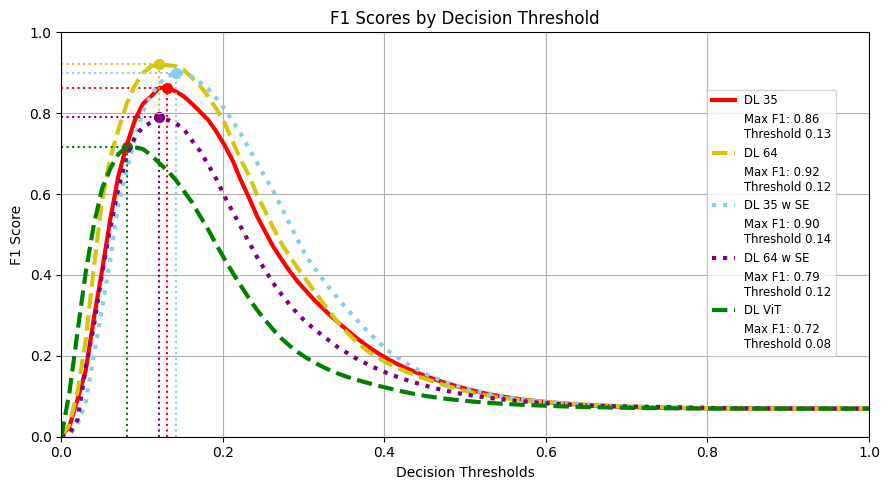

In [ ]:
systems = [("35", "red", "solid", f_stats_dl, stats_dl),
           ("64", "#D3C710", "--", f_stats_dl_64, stats_dl_64),
           ("35 w SE", "skyblue", ":", f_stats_dl_se_35, stats_dl_se_35),
           ("64 w SE", "purple", ":", f_stats_dl_se_64, stats_dl_se_64),
           ("ViT", "green", "--", f_stats_dl_vit, stats_dl_vit)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'DL {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f}\nThreshold {max_threshold:.2f}')
plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=[0.8,0.2], fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

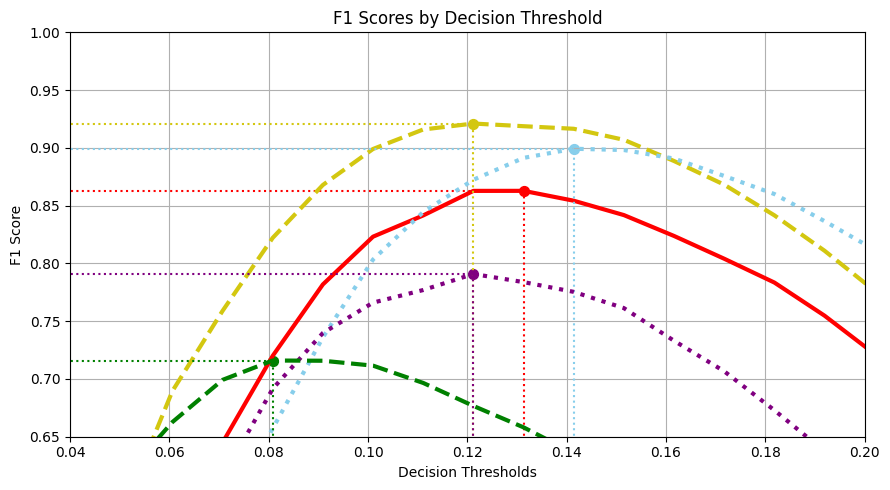

In [ ]:
systems = [("35", "red", "solid", f_stats_dl, stats_dl),
           ("64", "#D3C710", "--", f_stats_dl_64, stats_dl_64),
           ("35 w SE", "skyblue", ":", f_stats_dl_se_35, stats_dl_se_35),
           ("64 w SE", "purple", ":", f_stats_dl_se_64, stats_dl_se_64),
           ("vit", "green", "--", f_stats_dl_vit, stats_dl_vit)]

"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5))
for typeM, color, mark, f_stat, _ in systems:
    f1 = f_stat[0]
    max_f1_index = np.argmax(f1)
    max_f1 = f1[max_f1_index]
    max_threshold = thresholds[max_f1_index]
    plt.plot(thresholds, f1, color=color, linestyle=mark, label=f'DL {typeM}', linewidth=3)
    plt.scatter(max_threshold, max_f1, color=color, s=50)
    plt.vlines(max_threshold, 0, max_f1, color=color, linestyle='dotted')
    plt.hlines(max_f1, 0, max_threshold, color=color, linestyle='dotted')
    plt.plot([], [], ' ', label=f'Max F1: {max_f1:.2f}')

plt.title('F1 Scores by Decision Threshold')
plt.xlabel('Decision Thresholds')
plt.ylabel('F1 Score')
plt.xlim(0.04,0.2)
plt.ylim(0.65,1)
plt.grid(True)
plt.tight_layout()
plt.show()

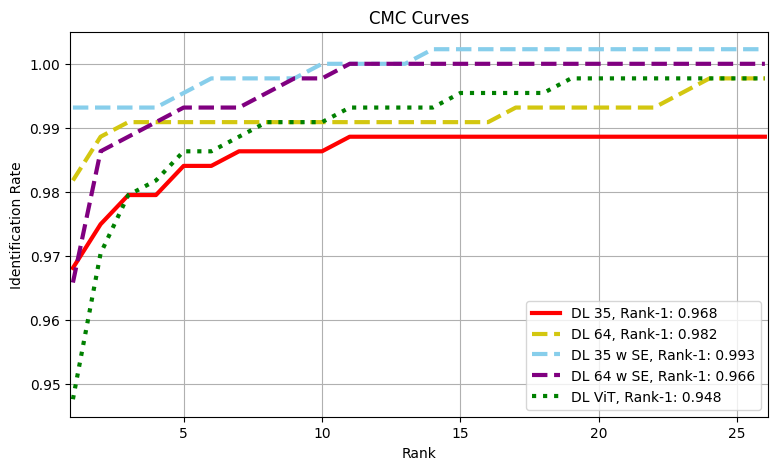

In [ ]:
systems_cmc = [("35", "red", "solid", pairwise_dl),
                ("64", "#D3C710", "--", pairwise_dl_64),
               ("35 w SE", "skyblue", "--", pairwise_dl_se_35),
                ("64 w SE", "purple", "--", pairwise_dl_se_64),
               ("ViT", "green", ":", pairwise_dl_vit)]

"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (typeM, color, mark, sim) in enumerate(systems_cmc):
    cmc_curve, rank1 = calc_CMC(sim, dict_all, faces["target"])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmc_curve), len(cmc_curve))
    plt.plot(x, cmc_curve, linestyle=mark, label=f'DL {typeM}, Rank-1: {rank1:.3f}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xlim(0.9, 26.1)
    plt.grid(True)
    plt.legend()
plt.show()